In [9]:
# Import necessary standard packages
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

#import tensorflow_addons as tfa

In [2]:
df = pd.read_csv('fold1_test.csv')
df['split'] = np.random.randn(df.shape[0], 1)

msk = np.random.rand(len(df)) <= 0.8

train = df[msk]
test = df[~msk]

In [3]:
trainlist = train['filename'].tolist()

In [4]:
len(trainlist)

2349

In [5]:
testlist = test['filename'].tolist()

In [6]:
import os
path = os.path.abspath(os.getcwd())

In [7]:
trainfiles = []
for f in os.listdir(path):
    file = 'audio/'+f
    if file in trainlist:
        trainfiles.append(f)

In [8]:
testfiles = []
for f in os.listdir(path):
    file = 'audio/'+f
    if file in testlist:
        testfiles.append(f)

In [10]:
trainfiles = []
for f in os.listdir(path):
    file = 'audio/'+f
    if file in trainlist:
        trainfiles.append(f)

In [11]:
def get_label(filepath):
    '''Receives a path to a video and returns its label
    '''
    scn_dict = {'airport': 0, 'shopping_mall': 1, 'metro_station': 2, 
                'street_pedestrian': 3, 'public_square': 4, 'street_traffic': 5,
                'tram': 6, 'bus': 7, 'metro': 8, 'park': 9}
    
    fileid = Path(filepath).name
    scn_id = fileid.split('-')[0]
    label = scn_dict[scn_id]
    return label

# Get labels
train_labels = [get_label(f) for f in trainfiles]
test_labels = [get_label(f) for f in testfiles]

In [12]:
#source: https://medium.com/@hasithsura/audio-classification-d37a82d6715
import numpy as np
import librosa
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db


In [13]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

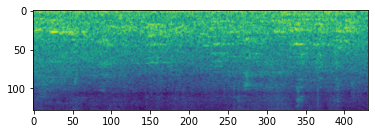

In [200]:
import torchvision
img = spec_to_image(get_melspectrogram_db("C:\\Users\\mdsp\\Downloads\\experiments\\test\\airport-lisbon-1175-45070-c.wav"))
plt.imshow(img)

In [27]:
import os
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader

In [46]:
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset
from PIL import Image



class DCaseDataset(Dataset):
    """
    Dataloader for DCase dataset
    Structure of the class is taken from:
    https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb
    """

    labelind2name = {
        0: "airport",
        1: "bus",
        2: "metro",
        3: "metro_station",
        4: "park",
        5: "public_square",
        6: "shopping_mall",
        7: "street_pedestrian",
        8: "street_traffic",
        9: "tram",
    }
    name2labelind = {
        "airport": 0,
        "bus": 1,
        "metro": 2,
        "metro_station": 3,
        "park": 4,
        "public_square": 5,
        "shopping_mall": 6,
        "street_pedestrian": 7,
        "street_traffic": 8,
        "tram": 9,
    }

    def __init__(self, root_dir, csv_path, indices):
        """

        :param root_dir:
        :param split:
        """
        # Open csv files
        self.root_dir = path

        csvData = pd.read_csv(csv_path, sep="\t")
        csvData["label"] = csvData.apply(lambda x: x["filename"].split('/')[1].split("-")[0], axis=1)
        #metaData = pd.read_csv(meta_path, sep="\t") if meta_path is not None else None

        # In test mode, just get file list
        #if split == "test":
        #    self.file_names = []
        #    for i in range(0, len(csvData)):
        #        self.file_names.append(csvData.iloc[i, 0])
        #    return

        # Lists of file names and labels
        self.labels, self.data = [], []
        
        for i in indices:
            filename = csvData.iloc[i, 0].split('/')[1]
            if (csvData.iloc[i, 0].split('/')[1]) in os.listdir(os.path.join(path, "test")):
                #self.file_names.append(csvData.iloc[i, 0].split('/')[1])
                image = spec_to_image(get_melspectrogram_db(os.path.join(path, "test", csvData.iloc[i, 0].split('/')[1])))
                self.data.append(image[np.newaxis,...])
                label = filename.split("-")[0]
                self.labels.append(self.name2labelind[label])
    def __getitem__(self, index):
        """

        :param index:
        :return:
        """

        # Load data
        #filepath = os.path.join(self.root_dir, 'test',self.file_names[index])
        #sound, sfreq = torchaudio.load(filepath, normalize=True)
        #assert sound.shape[0] == 1, "Expected mono channel"
        #sound = torch.mean(sound, dim=0)
        #assert sfreq == 44100, "Expected sampling rate of 44.1 kHz"

        # Remove last samples if longer than expected
        #if sound.shape[-1] >= 441000:
         #   sound = sound[:441000]

        return (self.data[index], self.labels[index])
    

    def __len__(self):
        return len(self.data)

In [47]:


root_dir = "C:\\Users\\mdsp\\Downloads\\experiments\\test\\"
csv_path = "C:\\Users\\mdsp\\Downloads\\experiments\\fold1_test.csv"

N = len(os.listdir(root_dir))
train_indices, test_indices = train_test_split(np.arange(0,N), test_size=0.33)

train_dataset = DCaseDataset(root_dir, csv_path, train_indices)
test_dataset = DCaseDataset(root_dir, csv_path, test_indices)

In [48]:
# import pandas as pd
# import torch
# import torchaudio
# from torch.utils.data import Dataset


# class DCaseDataset(Dataset):
#     """
#     Dataloader for DCase dataset
#     Structure of the class is taken from:
#     https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb
#     """
    
#     def __init__(self, path, files, labels):
 
#         self.file_names, self.labels = [], []
#         for i in range(len(files)):
#             self.file_names.append(files[i])
#             self.labels.append(labels[i])


#     def __getitem__(self, index):
#         """

#         :param index:
#         :return:
#         """

#         # Load data
#         filepath = path + self.file_names[index]
#         sound, sfreq = torchaudio.load(filepath, normalize=True)
#         assert sound.shape[0] == 1, "Expected mono channel"
#         sound = torch.mean(sound, dim=0)
#         assert sfreq == 44100, "Expected sampling rate of 44.1 kHz"

#         # Remove last samples if longer than expected
#         if sound.shape[-1] >= 441000:
#             sound = sound[:441000]

#         return (
#                 sound,
#                 self.labels[index],
#                 self.file_names[index]
#             )

#     def __len__(self):
#         return len(self.file_names)
    
    

In [49]:
import os
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from sp4asc.models.cnns import LogMelSpectrogram
from sp4asc.models import get_net
from sp4asc.training import TrainingManager

In [50]:
#N = len(os.listdir(root_dir))
#train_indices, test_indices = train_test_split(np.arange(0,N), test_size=0.33)

#train_dataset = DCaseDataset(root_dir, csv_path, train_indices)
#test_dataset = DCaseDataset(root_dir, csv_path, test_indices)

In [114]:
import torch.nn.functional as F
class SimpleCNN(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=10):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [177]:
from torchvision.models import resnet34
import torch
import torch.nn as nn
import torch.optim as optim
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
net = resnet34(pretrained=True)
net.fc = nn.Linear(512,10)
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net = net.to(device)

In [178]:
config = {
    "batchsize": 32,
    "num_workers": 0,
    "reload": False,
    "net": net,
    "dropout": 0.2,
    "specAugment": [128, 2, 16, 2],
    "lr": 1e-3,
    "eta_min": 1e-5,
    "max_epoch": 100,
    "weight_decay": 1e-5,
    "mixup_alpha": 0.2,
    "out_dir": "C:\\Users\\mdsp\\Downloads\\experiments",
}

In [179]:

loader_train = DataLoader(
        train_dataset,
        batch_size=config["batchsize"],
        shuffle=True,
        pin_memory=True,
        num_workers=config["num_workers"],
        drop_last=True,
    )

loader_test = DataLoader(
    test_dataset,
    batch_size=config["batchsize"],
    shuffle=False,
    pin_memory=True,
    num_workers=config["num_workers"],
    drop_last=False,
    
)

In [180]:
from tqdm import tqdm
learning_rate = config["lr"]
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
num_epochs = 50
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
valid_losses=[]

def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer


def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [181]:
train(net, loss_fn, loader_train, loader_test, num_epochs, optimizer, train_losses, valid_losses, lr_decay)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.8288787688527788


  2%|█▋                                                                                 | 1/50 [00:58<48:09, 58.97s/it]

Epoch - 1 Valid-Loss : 4.8217496869147 Valid-Accuracy : 0.46511627906976744
Epoch - 2 Train-Loss : 0.8580061580453601


  4%|███▎                                                                               | 2/50 [02:14<54:50, 68.56s/it]

Epoch - 2 Valid-Loss : 3.488791547046276 Valid-Accuracy : 0.4573643410852713
Epoch - 3 Train-Loss : 0.7167901992797852


  6%|████▉                                                                              | 3/50 [03:29<56:09, 71.68s/it]

Epoch - 3 Valid-Loss : 11.092498588562012 Valid-Accuracy : 0.4806201550387597
Epoch - 4 Train-Loss : 0.6208443897111076


  8%|██████▋                                                                            | 4/50 [04:33<52:35, 68.61s/it]

Epoch - 4 Valid-Loss : 3.655977725982666 Valid-Accuracy : 0.5968992248062015
Epoch - 5 Train-Loss : 0.5755802307810102


 10%|████████▎                                                                          | 5/50 [05:37<50:06, 66.81s/it]

Epoch - 5 Valid-Loss : 1.9150365347668412 Valid-Accuracy : 0.6201550387596899
Epoch - 6 Train-Loss : 0.45717371361596243


 12%|█████████▉                                                                         | 6/50 [06:39<47:55, 65.34s/it]

Epoch - 6 Valid-Loss : 0.9368767321109772 Valid-Accuracy : 0.6666666666666666
Epoch - 7 Train-Loss : 0.39255495582308086


 14%|███████████▌                                                                       | 7/50 [07:49<47:59, 66.97s/it]

Epoch - 7 Valid-Loss : 0.8027881717309355 Valid-Accuracy : 0.7054263565891473
Epoch - 8 Train-Loss : 0.4031840371234076


 16%|█████████████▎                                                                     | 8/50 [08:55<46:39, 66.67s/it]

Epoch - 8 Valid-Loss : 1.1831679821014405 Valid-Accuracy : 0.5503875968992248
Epoch - 9 Train-Loss : 0.32674453939710346


 18%|██████████████▉                                                                    | 9/50 [09:58<44:41, 65.41s/it]

Epoch - 9 Valid-Loss : 1.5431938648223877 Valid-Accuracy : 0.4806201550387597
Changed learning rate to 0.0001
Epoch - 10 Train-Loss : 0.3289032259157726


 20%|████████████████▍                                                                 | 10/50 [10:58<42:24, 63.60s/it]

Epoch - 10 Valid-Loss : 0.9824358444660902 Valid-Accuracy : 0.689922480620155
Epoch - 11 Train-Loss : 0.23337750562599727


 22%|██████████████████                                                                | 11/50 [11:57<40:23, 62.15s/it]

Epoch - 11 Valid-Loss : 0.7323059780988842 Valid-Accuracy : 0.7829457364341085
Epoch - 12 Train-Loss : 0.1972145778792245


 24%|███████████████████▋                                                              | 12/50 [12:57<39:02, 61.65s/it]

Epoch - 12 Valid-Loss : 0.6982910063117742 Valid-Accuracy : 0.7906976744186046
Epoch - 13 Train-Loss : 0.13107014553887503


 26%|█████████████████████▎                                                            | 13/50 [13:56<37:30, 60.81s/it]

Epoch - 13 Valid-Loss : 0.6631014354526996 Valid-Accuracy : 0.8217054263565892
Epoch - 14 Train-Loss : 0.1118703346167292


 28%|██████████████████████▉                                                           | 14/50 [14:56<36:18, 60.50s/it]

Epoch - 14 Valid-Loss : 0.6549889549612999 Valid-Accuracy : 0.7984496124031008
Epoch - 15 Train-Loss : 0.09703839783157621


 30%|████████████████████████▌                                                         | 15/50 [15:55<35:00, 60.00s/it]

Epoch - 15 Valid-Loss : 0.7006605934351683 Valid-Accuracy : 0.7906976744186046
Epoch - 16 Train-Loss : 0.09714842694146293


 32%|██████████████████████████▏                                                       | 16/50 [17:03<35:25, 62.50s/it]

Epoch - 16 Valid-Loss : 0.6789605420082807 Valid-Accuracy : 0.7984496124031008
Epoch - 17 Train-Loss : 0.06783532723784447


 34%|███████████████████████████▉                                                      | 17/50 [18:05<34:18, 62.39s/it]

Epoch - 17 Valid-Loss : 0.6836207777261734 Valid-Accuracy : 0.813953488372093
Epoch - 18 Train-Loss : 0.09659630219851222


 36%|█████████████████████████████▌                                                    | 18/50 [19:04<32:47, 61.49s/it]

Epoch - 18 Valid-Loss : 0.7431407939642668 Valid-Accuracy : 0.7984496124031008
Epoch - 19 Train-Loss : 0.05241064115294388


 38%|███████████████████████████████▏                                                  | 19/50 [20:02<31:13, 60.44s/it]

Epoch - 19 Valid-Loss : 0.7187125749886036 Valid-Accuracy : 0.7984496124031008
Changed learning rate to 1e-05
Epoch - 20 Train-Loss : 0.05559145526162216


 40%|████████████████████████████████▊                                                 | 20/50 [21:00<29:50, 59.67s/it]

Epoch - 20 Valid-Loss : 0.7149894546717406 Valid-Accuracy : 0.7984496124031008
Epoch - 21 Train-Loss : 0.04665968327650002


 42%|██████████████████████████████████▍                                               | 21/50 [21:59<28:38, 59.27s/it]

Epoch - 21 Valid-Loss : 0.7094673234038055 Valid-Accuracy : 0.7984496124031008
Epoch - 22 Train-Loss : 0.04387891838060958


 44%|████████████████████████████████████                                              | 22/50 [22:57<27:35, 59.12s/it]

Epoch - 22 Valid-Loss : 0.7089421196375042 Valid-Accuracy : 0.8062015503875969
Epoch - 23 Train-Loss : 0.07602312389229025


 46%|█████████████████████████████████████▋                                            | 23/50 [23:59<26:55, 59.83s/it]

Epoch - 23 Valid-Loss : 0.7004803098272532 Valid-Accuracy : 0.8217054263565892
Epoch - 24 Train-Loss : 0.042423967005951066


 48%|███████████████████████████████████████▎                                          | 24/50 [25:03<26:28, 61.10s/it]

Epoch - 24 Valid-Loss : 0.689148127567023 Valid-Accuracy : 0.8217054263565892
Epoch - 25 Train-Loss : 0.041355236300400326


 50%|█████████████████████████████████████████                                         | 25/50 [26:04<25:29, 61.16s/it]

Epoch - 25 Valid-Loss : 0.6845182683318853 Valid-Accuracy : 0.8294573643410853
Epoch - 26 Train-Loss : 0.049479250397001


 52%|██████████████████████████████████████████▋                                       | 26/50 [27:02<24:03, 60.15s/it]

Epoch - 26 Valid-Loss : 0.6888648147694767 Valid-Accuracy : 0.8217054263565892
Epoch - 27 Train-Loss : 0.046744181375418394


 54%|████████████████████████████████████████████▎                                     | 27/50 [28:00<22:47, 59.47s/it]

Epoch - 27 Valid-Loss : 0.6889071431010961 Valid-Accuracy : 0.8217054263565892
Epoch - 28 Train-Loss : 0.0537324169916766


 56%|█████████████████████████████████████████████▉                                    | 28/50 [29:00<21:52, 59.66s/it]

Epoch - 28 Valid-Loss : 0.6906542969867587 Valid-Accuracy : 0.813953488372093
Epoch - 29 Train-Loss : 0.02991736706878458


 58%|███████████████████████████████████████████████▌                                  | 29/50 [29:59<20:46, 59.34s/it]

Epoch - 29 Valid-Loss : 0.6852315049152822 Valid-Accuracy : 0.813953488372093
Changed learning rate to 1e-06
Epoch - 30 Train-Loss : 0.04235176609030792


 60%|█████████████████████████████████████████████████▏                                | 30/50 [30:57<19:42, 59.11s/it]

Epoch - 30 Valid-Loss : 0.6839523600414396 Valid-Accuracy : 0.813953488372093
Epoch - 31 Train-Loss : 0.06763510938201632


 62%|██████████████████████████████████████████████████▊                               | 31/50 [31:57<18:44, 59.19s/it]

Epoch - 31 Valid-Loss : 0.6932043011300266 Valid-Accuracy : 0.8062015503875969
Epoch - 32 Train-Loss : 0.047619078042251725


 64%|████████████████████████████████████████████████████▍                             | 32/50 [32:56<17:45, 59.18s/it]

Epoch - 32 Valid-Loss : 0.693903052341193 Valid-Accuracy : 0.813953488372093
Epoch - 33 Train-Loss : 0.04601430107972452


 66%|██████████████████████████████████████████████████████                            | 33/50 [33:54<16:40, 58.87s/it]

Epoch - 33 Valid-Loss : 0.6979000590741634 Valid-Accuracy : 0.8062015503875969
Epoch - 34 Train-Loss : 0.04450899429087128


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [34:54<15:50, 59.39s/it]

Epoch - 34 Valid-Loss : 0.6898154911585153 Valid-Accuracy : 0.813953488372093
Epoch - 35 Train-Loss : 0.04074464658541339


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [35:53<14:45, 59.01s/it]

Epoch - 35 Valid-Loss : 0.693277311231941 Valid-Accuracy : 0.813953488372093
Epoch - 36 Train-Loss : 0.04658311512321234


 72%|███████████████████████████████████████████████████████████                       | 36/50 [36:50<13:41, 58.67s/it]

Epoch - 36 Valid-Loss : 0.6922189458273351 Valid-Accuracy : 0.8062015503875969
Epoch - 37 Train-Loss : 0.044709015637636185


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [37:49<12:40, 58.49s/it]

Epoch - 37 Valid-Loss : 0.6837935484014451 Valid-Accuracy : 0.8294573643410853
Epoch - 38 Train-Loss : 0.05402277835777828


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [38:48<11:46, 58.86s/it]

Epoch - 38 Valid-Loss : 0.688833991670981 Valid-Accuracy : 0.8217054263565892
Epoch - 39 Train-Loss : 0.052223707150135724


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [39:50<10:55, 59.63s/it]

Epoch - 39 Valid-Loss : 0.6863296594470739 Valid-Accuracy : 0.8217054263565892
Changed learning rate to 1e-07
Epoch - 40 Train-Loss : 0.03898166811891964


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [40:47<09:50, 59.07s/it]

Epoch - 40 Valid-Loss : 0.6958335057832301 Valid-Accuracy : 0.8217054263565892
Epoch - 41 Train-Loss : 0.03983918537518808


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [41:45<08:47, 58.64s/it]

Epoch - 41 Valid-Loss : 0.6934768633451313 Valid-Accuracy : 0.813953488372093
Epoch - 42 Train-Loss : 0.04037620898868356


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [42:43<07:46, 58.31s/it]

Epoch - 42 Valid-Loss : 0.6921932221390307 Valid-Accuracy : 0.813953488372093
Epoch - 43 Train-Loss : 0.039695191596235545


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [43:40<06:46, 58.12s/it]

Epoch - 43 Valid-Loss : 0.6855346988886595 Valid-Accuracy : 0.8217054263565892
Epoch - 44 Train-Loss : 0.05957386230251619


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [44:39<05:50, 58.37s/it]

Epoch - 44 Valid-Loss : 0.6891317132860422 Valid-Accuracy : 0.813953488372093
Epoch - 45 Train-Loss : 0.03476398677698204


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [45:40<04:55, 59.17s/it]

Epoch - 45 Valid-Loss : 0.687094866624102 Valid-Accuracy : 0.8217054263565892
Epoch - 46 Train-Loss : 0.04823070125920432


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [46:39<03:56, 59.07s/it]

Epoch - 46 Valid-Loss : 0.6824040735140443 Valid-Accuracy : 0.813953488372093
Epoch - 47 Train-Loss : 0.04829191203628268


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [47:37<02:56, 58.74s/it]

Epoch - 47 Valid-Loss : 0.6867652035318315 Valid-Accuracy : 0.8294573643410853
Epoch - 48 Train-Loss : 0.05388195253908634


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [48:35<01:57, 58.60s/it]

Epoch - 48 Valid-Loss : 0.6882941144052893 Valid-Accuracy : 0.813953488372093
Epoch - 49 Train-Loss : 0.047913944880877225


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [49:33<00:58, 58.29s/it]

Epoch - 49 Valid-Loss : 0.6839824893977493 Valid-Accuracy : 0.813953488372093
Changed learning rate to 1e-08
Epoch - 50 Train-Loss : 0.07739561876016003


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [50:33<00:00, 60.67s/it]

Epoch - 50 Valid-Loss : 0.6881342974957079 Valid-Accuracy : 0.813953488372093


In [182]:
torch.save(net.state_dict(),"C:\\Users\\mdsp\\Downloads\\experiments\\model\\checkpoint.pt")

In [183]:
net

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [184]:
total_params = sum(p.numel() for p in net.parameters())
total_params

21283530

## Pruning

In [185]:
from torch.nn.utils import prune

In [186]:
def get_prunable_modules(net):
    modules_to_prune = []
    for i, m in enumerate(list(net.named_modules())):
        if isinstance(m[1], torch.nn.Conv2d):
            modules_to_prune.append(net.get_submodule(m[0]))
    return modules_to_prune

In [187]:
modules_to_prune = get_prunable_modules(net)
modules_to_prune

[Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 

In [188]:
# Helper Function to determine the min, max and average sparsity of the prunable modules
def get_sparsity(modules):
    sparsities = []
    for m in modules:
        sparsities.append(((m.weight == 0).sum()/m.weight.numel()).item())
    sparsities = torch.Tensor(sparsities)
    return {
        'min':sparsities.min().item(), 
        'max':sparsities.max().item(), 
        'mean':sparsities.mean().item()}

In [189]:
img_batch, label_batch = next(iter(loader_train))

In [190]:
def batch_accuracy(net, img_batch, label_batch):
    optimizer.zero_grad()
    img_batch, label_batch = img_batch.to(device), label_batch.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    predictions = net(img_batch)
    # calculate training accuracy
    predicted_labels = predictions.argmax(dim=1, keepdim=True).squeeze()
    num_train_correct = (predicted_labels == label_batch).sum().item()
    train_accuracy = num_train_correct / label_batch.size(0)
    return train_accuracy

In [191]:
get_sparsity(modules_to_prune)

{'min': 0.0, 'max': 0.0, 'mean': 0.0}

In [192]:
def l1_prune(modules, amount):
    for m in modules:
        prune.L1Unstructured(.0).apply(m, 'weight', amount)
    return get_sparsity(modules)

In [193]:
l1_prune(modules_to_prune, .5)

{'min': 0.5, 'max': 0.5, 'mean': 0.5}

In [194]:
get_sparsity(modules_to_prune)


{'min': 0.5, 'max': 0.5, 'mean': 0.5}

## Fine-tuning resnet

In [195]:
#https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11041/110412J/Pruning-filters-with-L1-norm-and-standard-deviation-for-CNN/10.1117/12.2523246.short?SSO=1

In [196]:
from torchvision.models import resnet34
def load_resnet(MODEL_PATH, pruned=False):
    net = resnet34(pretrained=True)

    net.fc = nn.Linear(512,10)
    net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  
    if pruned==True:
        modules_to_prune = pruning_utils.get_prunable_modules(net)
        pruning_utils.l1_prune(modules_to_prune, .0)
    print(type(net))
    state_dict = torch.load(MODEL_PATH)
    net.load_state_dict(state_dict)
    model = net
    net.eval()
    return net

In [197]:
epochs = 25
modules_to_prune = get_prunable_modules(net)

print(get_sparsity(modules_to_prune))


l1_prune(modules_to_prune, .5)
cpr2_state_dict = train(net, loss_fn, loader_train, loader_test, 25, optimizer, train_losses, valid_losses, lr_decay)
print(get_sparsity(modules_to_prune))

SAVE_PATH = "C:\\Users\\mdsp\\Downloads\\experiments\\model\\checkpoint-pruning2.pt"
torch.save(net.state_dict(), SAVE_PATH)

l1_prune(modules_to_prune, .5)
cpr2_state_dict = train(net, loss_fn, loader_train, loader_test, 25, optimizer, train_losses, valid_losses, lr_decay)
print(get_sparsity(modules_to_prune))

SAVE_PATH = "C:\\Users\\mdsp\\Downloads\\experiments\\model\\checkpoint-pruning4.pt"
torch.save(net.state_dict(), SAVE_PATH)


l1_prune(modules_to_prune, .5)
cpr2_state_dict = train(net, loss_fn, loader_train, loader_test, 25, optimizer, train_losses, valid_losses, lr_decay)
print(get_sparsity(modules_to_prune))

SAVE_PATH = "C:\\Users\\mdsp\\Downloads\\experiments\\model\\checkpoint-pruning8.pt"
torch.save(net.state_dict(), SAVE_PATH)

l1_prune(modules_to_prune, .5)
cpr2_state_dict = train(net, loss_fn, loader_train, loader_test, 25, optimizer, train_losses, valid_losses, lr_decay)
print(get_sparsity(modules_to_prune))

SAVE_PATH = "C:\\Users\\mdsp\\Downloads\\experiments\\model\\checkpoint-pruning16.pt"
torch.save(net.state_dict(), SAVE_PATH)


{'min': 0.5, 'max': 0.5, 'mean': 0.5}


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.5036224488701139


  4%|███▎                                                                               | 1/25 [01:15<30:01, 75.07s/it]

Epoch - 1 Valid-Loss : 1.3384422063827515 Valid-Accuracy : 0.4573643410852713
Epoch - 2 Train-Loss : 0.5069762021303177


  8%|██████▋                                                                            | 2/25 [02:28<28:30, 74.35s/it]

Epoch - 2 Valid-Loss : 1.321206697821617 Valid-Accuracy : 0.46511627906976744
Epoch - 3 Train-Loss : 0.5139997005462646


 12%|█████████▉                                                                         | 3/25 [03:40<26:50, 73.19s/it]

Epoch - 3 Valid-Loss : 1.141616405546665 Valid-Accuracy : 0.5038759689922481
Epoch - 4 Train-Loss : 0.5037776061466762


 16%|█████████████▎                                                                     | 4/25 [05:01<26:36, 76.03s/it]

Epoch - 4 Valid-Loss : 1.1652547745034099 Valid-Accuracy : 0.5891472868217055
Epoch - 5 Train-Loss : 0.43741738370486666


 20%|████████████████▌                                                                  | 5/25 [06:17<25:24, 76.23s/it]

Epoch - 5 Valid-Loss : 1.0718161206692458 Valid-Accuracy : 0.6124031007751938
Epoch - 6 Train-Loss : 0.46400441016469685


 24%|███████████████████▉                                                               | 6/25 [07:20<22:40, 71.62s/it]

Epoch - 6 Valid-Loss : 0.9134369435254485 Valid-Accuracy : 0.6589147286821705
Epoch - 7 Train-Loss : 0.5481585093906948


 28%|███████████████████████▏                                                           | 7/25 [08:18<20:08, 67.14s/it]

Epoch - 7 Valid-Loss : 0.8338201063685119 Valid-Accuracy : 0.6821705426356589
Epoch - 8 Train-Loss : 0.5030615457466671


 32%|██████████████████████████▌                                                        | 8/25 [09:16<18:13, 64.34s/it]

Epoch - 8 Valid-Loss : 0.8060896436683833 Valid-Accuracy : 0.6976744186046512
Epoch - 9 Train-Loss : 0.4743346231324332


 36%|█████████████████████████████▉                                                     | 9/25 [10:15<16:41, 62.59s/it]

Epoch - 9 Valid-Loss : 0.7940035100094974 Valid-Accuracy : 0.7209302325581395
Changed learning rate to 0.0001
Epoch - 10 Train-Loss : 0.32849370156015667


 40%|████████████████████████████████▊                                                 | 10/25 [11:15<15:26, 61.78s/it]

Epoch - 10 Valid-Loss : 1.0950748544186353 Valid-Accuracy : 0.6976744186046512
Epoch - 11 Train-Loss : 0.35500217761312214


 44%|████████████████████████████████████                                              | 11/25 [12:26<15:04, 64.57s/it]

Epoch - 11 Valid-Loss : 0.7940998360747471 Valid-Accuracy : 0.751937984496124
Epoch - 12 Train-Loss : 0.22747522166797093


 48%|███████████████████████████████████████▎                                          | 12/25 [13:36<14:20, 66.19s/it]

Epoch - 12 Valid-Loss : 0.715284176915884 Valid-Accuracy : 0.7441860465116279
Epoch - 13 Train-Loss : 0.21283856566463197


 52%|██████████████████████████████████████████▋                                       | 13/25 [14:46<13:28, 67.41s/it]

Epoch - 13 Valid-Loss : 0.6992868483066559 Valid-Accuracy : 0.751937984496124
Epoch - 14 Train-Loss : 0.15801660929407393


 56%|█████████████████████████████████████████████▉                                    | 14/25 [15:49<12:05, 65.98s/it]

Epoch - 14 Valid-Loss : 0.6220370441675186 Valid-Accuracy : 0.7984496124031008
Epoch - 15 Train-Loss : 0.09991742670536041


 60%|█████████████████████████████████████████████████▏                                | 15/25 [16:55<10:59, 66.00s/it]

Epoch - 15 Valid-Loss : 0.6348095834255219 Valid-Accuracy : 0.7906976744186046
Epoch - 16 Train-Loss : 0.08888654464057513


 64%|████████████████████████████████████████████████████▍                             | 16/25 [18:24<10:57, 73.02s/it]

Epoch - 16 Valid-Loss : 0.6112592197954655 Valid-Accuracy : 0.7984496124031008
Epoch - 17 Train-Loss : 0.09011445992759295


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [19:45<10:04, 75.58s/it]

Epoch - 17 Valid-Loss : 0.6095143921673298 Valid-Accuracy : 0.8294573643410853
Epoch - 18 Train-Loss : 0.06633471910442625


 72%|███████████████████████████████████████████████████████████                       | 18/25 [20:56<08:37, 73.93s/it]

Epoch - 18 Valid-Loss : 0.6801795395091176 Valid-Accuracy : 0.8217054263565892
Epoch - 19 Train-Loss : 0.05432363386665072


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [22:04<07:14, 72.40s/it]

Epoch - 19 Valid-Loss : 0.6651907930150628 Valid-Accuracy : 0.7906976744186046
Changed learning rate to 1e-05
Epoch - 20 Train-Loss : 0.05968992545136383


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [23:12<05:54, 70.84s/it]

Epoch - 20 Valid-Loss : 0.6693784444592893 Valid-Accuracy : 0.7829457364341085
Epoch - 21 Train-Loss : 0.04692141445619719


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [24:20<04:41, 70.25s/it]

Epoch - 21 Valid-Loss : 0.6617363220080733 Valid-Accuracy : 0.7906976744186046
Epoch - 22 Train-Loss : 0.04177303851715156


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [25:33<03:32, 70.98s/it]

Epoch - 22 Valid-Loss : 0.6602042439393699 Valid-Accuracy : 0.7829457364341085
Epoch - 23 Train-Loss : 0.05187378025480679


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [26:40<02:19, 69.74s/it]

Epoch - 23 Valid-Loss : 0.6573807409964502 Valid-Accuracy : 0.7829457364341085
Epoch - 24 Train-Loss : 0.0463237055976476


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [27:51<01:10, 70.00s/it]

Epoch - 24 Valid-Loss : 0.6573199917562306 Valid-Accuracy : 0.7829457364341085
Epoch - 25 Train-Loss : 0.0297755878418684


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [28:53<00:00, 69.32s/it]

Epoch - 25 Valid-Loss : 0.6572047710418701 Valid-Accuracy : 0.7829457364341085
{'min': 0.75, 'max': 0.75, 'mean': 0.75}



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.5486639865807125


  4%|███▎                                                                               | 1/25 [01:06<26:37, 66.57s/it]

Epoch - 1 Valid-Loss : 1.3348621010780335 Valid-Accuracy : 0.4728682170542636
Epoch - 2 Train-Loss : 0.4354224907500403


  8%|██████▋                                                                            | 2/25 [02:13<25:32, 66.63s/it]

Epoch - 2 Valid-Loss : 1.4993152618408203 Valid-Accuracy : 0.4806201550387597
Epoch - 3 Train-Loss : 0.33032033911773134


 12%|█████████▉                                                                         | 3/25 [03:18<24:14, 66.10s/it]

Epoch - 3 Valid-Loss : 1.4333738803863525 Valid-Accuracy : 0.4573643410852713
Epoch - 4 Train-Loss : 0.30076367940221516


 16%|█████████████▎                                                                     | 4/25 [04:16<22:00, 62.89s/it]

Epoch - 4 Valid-Loss : 1.0007017850875854 Valid-Accuracy : 0.5891472868217055
Epoch - 5 Train-Loss : 0.2771473580173084


 20%|████████████████▌                                                                  | 5/25 [05:17<20:44, 62.21s/it]

Epoch - 5 Valid-Loss : 0.8886496521532535 Valid-Accuracy : 0.6821705426356589
Epoch - 6 Train-Loss : 0.23024396491902216


 24%|███████████████████▉                                                               | 6/25 [06:16<19:18, 60.98s/it]

Epoch - 6 Valid-Loss : 0.8476478748954832 Valid-Accuracy : 0.7209302325581395
Epoch - 7 Train-Loss : 0.1493331098130771


 28%|███████████████████████▏                                                           | 7/25 [07:15<18:08, 60.46s/it]

Epoch - 7 Valid-Loss : 0.808783071115613 Valid-Accuracy : 0.7286821705426356
Epoch - 8 Train-Loss : 0.18279961496591568


 32%|██████████████████████████▌                                                        | 8/25 [08:15<17:02, 60.16s/it]

Epoch - 8 Valid-Loss : 0.7921865439042449 Valid-Accuracy : 0.7286821705426356
Epoch - 9 Train-Loss : 0.1623867303133011


 36%|█████████████████████████████▉                                                     | 9/25 [09:14<15:59, 59.96s/it]

Epoch - 9 Valid-Loss : 0.7754608658142388 Valid-Accuracy : 0.7286821705426356
Changed learning rate to 0.0001
Epoch - 10 Train-Loss : 0.12376686345253672


 40%|████████████████████████████████▊                                                 | 10/25 [10:17<15:13, 60.89s/it]

Epoch - 10 Valid-Loss : 0.7433664444833994 Valid-Accuracy : 0.7364341085271318
Epoch - 11 Train-Loss : 0.08067611871021134


 44%|████████████████████████████████████                                              | 11/25 [11:25<14:41, 62.93s/it]

Epoch - 11 Valid-Loss : 0.7610210033133626 Valid-Accuracy : 0.7286821705426356
Epoch - 12 Train-Loss : 0.06327787786722183


 48%|███████████████████████████████████████▎                                          | 12/25 [12:23<13:18, 61.44s/it]

Epoch - 12 Valid-Loss : 0.8032415842870251 Valid-Accuracy : 0.7209302325581395
Epoch - 13 Train-Loss : 0.06014050862618855


 52%|██████████████████████████████████████████▋                                       | 13/25 [13:20<12:03, 60.27s/it]

Epoch - 13 Valid-Loss : 0.7359138481318951 Valid-Accuracy : 0.7674418604651163
Epoch - 14 Train-Loss : 0.04220495027090822


 56%|█████████████████████████████████████████████▉                                    | 14/25 [14:18<10:55, 59.55s/it]

Epoch - 14 Valid-Loss : 0.7470941420644521 Valid-Accuracy : 0.7364341085271318
Epoch - 15 Train-Loss : 0.04163457679429224


 60%|█████████████████████████████████████████████████▏                                | 15/25 [15:17<09:51, 59.17s/it]

Epoch - 15 Valid-Loss : 0.8279018326662481 Valid-Accuracy : 0.7286821705426356
Epoch - 16 Train-Loss : 0.026300876534410884


 64%|████████████████████████████████████████████████████▍                             | 16/25 [16:18<08:59, 59.98s/it]

Epoch - 16 Valid-Loss : 0.789048733143136 Valid-Accuracy : 0.7906976744186046
Epoch - 17 Train-Loss : 0.03166951398764338


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [17:18<07:57, 59.73s/it]

Epoch - 17 Valid-Loss : 0.7770881779957562 Valid-Accuracy : 0.7751937984496124
Epoch - 18 Train-Loss : 0.014584470606808151


 72%|███████████████████████████████████████████████████████████                       | 18/25 [18:17<06:56, 59.53s/it]

Epoch - 18 Valid-Loss : 0.9430304615758359 Valid-Accuracy : 0.7286821705426356
Epoch - 19 Train-Loss : 0.03757227737722652


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [19:20<06:03, 60.60s/it]

Epoch - 19 Valid-Loss : 0.7268978039734065 Valid-Accuracy : 0.7364341085271318
Changed learning rate to 1e-05
Epoch - 20 Train-Loss : 0.016432654445192645


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [20:18<04:58, 59.77s/it]

Epoch - 20 Valid-Loss : 0.7218970103189349 Valid-Accuracy : 0.7441860465116279
Epoch - 21 Train-Loss : 0.018258721833782538


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [21:17<03:58, 59.66s/it]

Epoch - 21 Valid-Loss : 0.7318137985188514 Valid-Accuracy : 0.7441860465116279
Epoch - 22 Train-Loss : 0.019290422355490073


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [22:24<03:05, 61.96s/it]

Epoch - 22 Valid-Loss : 0.7311290829442442 Valid-Accuracy : 0.7364341085271318
Epoch - 23 Train-Loss : 0.016651938669383526


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [23:23<02:01, 60.89s/it]

Epoch - 23 Valid-Loss : 0.7311948887072504 Valid-Accuracy : 0.7441860465116279
Epoch - 24 Train-Loss : 0.014881452146385397


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [24:30<01:02, 62.85s/it]

Epoch - 24 Valid-Loss : 0.7373802243964747 Valid-Accuracy : 0.751937984496124
Epoch - 25 Train-Loss : 0.015308694182229894


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [25:37<00:00, 61.52s/it]

Epoch - 25 Valid-Loss : 0.7397861872799695 Valid-Accuracy : 0.7364341085271318
{'min': 0.875, 'max': 0.875, 'mean': 0.875}



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.8662686518260411


  4%|███▎                                                                               | 1/25 [00:59<23:46, 59.43s/it]

Epoch - 1 Valid-Loss : 2.0995875358581544 Valid-Accuracy : 0.4418604651162791
Epoch - 2 Train-Loss : 0.7569217085838318


  8%|██████▋                                                                            | 2/25 [01:58<22:40, 59.16s/it]

Epoch - 2 Valid-Loss : 1.1577563524246215 Valid-Accuracy : 0.5348837209302325
Epoch - 3 Train-Loss : 0.4354088796036584


 12%|█████████▉                                                                         | 3/25 [02:55<21:25, 58.45s/it]

Epoch - 3 Valid-Loss : 1.0590355768799782 Valid-Accuracy : 0.5193798449612403
Epoch - 4 Train-Loss : 0.38511135429143906


 16%|█████████████▎                                                                     | 4/25 [03:54<20:25, 58.36s/it]

Epoch - 4 Valid-Loss : 1.013760290015489 Valid-Accuracy : 0.627906976744186
Epoch - 5 Train-Loss : 0.3003856816462108


 20%|████████████████▌                                                                  | 5/25 [04:52<19:30, 58.50s/it]

Epoch - 5 Valid-Loss : 0.904380793494056 Valid-Accuracy : 0.7441860465116279
Epoch - 6 Train-Loss : 0.2327467660818781


 24%|███████████████████▉                                                               | 6/25 [05:51<18:33, 58.61s/it]

Epoch - 6 Valid-Loss : 0.8434801809882628 Valid-Accuracy : 0.7441860465116279
Epoch - 7 Train-Loss : 0.1960634940436908


 28%|███████████████████████▏                                                           | 7/25 [06:52<17:48, 59.38s/it]

Epoch - 7 Valid-Loss : 0.8072707048486336 Valid-Accuracy : 0.7596899224806202
Epoch - 8 Train-Loss : 0.2701953702739307


 32%|██████████████████████████▌                                                        | 8/25 [07:52<16:51, 59.50s/it]

Epoch - 8 Valid-Loss : 0.7957127088942798 Valid-Accuracy : 0.7596899224806202
Epoch - 9 Train-Loss : 0.16220867953130177


 36%|█████████████████████████████▉                                                     | 9/25 [08:50<15:42, 58.88s/it]

Epoch - 9 Valid-Loss : 0.7989421366030001 Valid-Accuracy : 0.7751937984496124
Changed learning rate to 0.0001
Epoch - 10 Train-Loss : 0.13037302318428243


 40%|████████████████████████████████▊                                                 | 10/25 [09:51<14:53, 59.57s/it]

Epoch - 10 Valid-Loss : 0.8565077540748461 Valid-Accuracy : 0.7596899224806202
Epoch - 11 Train-Loss : 0.09126571991613933


 44%|████████████████████████████████████                                              | 11/25 [10:50<13:51, 59.39s/it]

Epoch - 11 Valid-Loss : 0.6803744711796753 Valid-Accuracy : 0.7829457364341085
Epoch - 12 Train-Loss : 0.048510922119021416


 48%|███████████████████████████████████████▎                                          | 12/25 [11:49<12:52, 59.46s/it]

Epoch - 12 Valid-Loss : 0.669598038791446 Valid-Accuracy : 0.7984496124031008
Epoch - 13 Train-Loss : 0.03137209386165653


 52%|██████████████████████████████████████████▋                                       | 13/25 [12:48<11:52, 59.37s/it]

Epoch - 13 Valid-Loss : 0.7000156625523232 Valid-Accuracy : 0.7674418604651163
Epoch - 14 Train-Loss : 0.03612478742642062


 56%|█████████████████████████████████████████████▉                                    | 14/25 [13:47<10:50, 59.12s/it]

Epoch - 14 Valid-Loss : 0.673840626119636 Valid-Accuracy : 0.7751937984496124
Epoch - 15 Train-Loss : 0.0409755775971072


 60%|█████████████████████████████████████████████████▏                                | 15/25 [14:45<09:49, 58.93s/it]

Epoch - 15 Valid-Loss : 0.6898146389125032 Valid-Accuracy : 0.7906976744186046
Epoch - 16 Train-Loss : 0.01762761761035238


 64%|████████████████████████████████████████████████████▍                             | 16/25 [15:44<08:48, 58.67s/it]

Epoch - 16 Valid-Loss : 0.6849880932408269 Valid-Accuracy : 0.7751937984496124
Epoch - 17 Train-Loss : 0.02426170451300485


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [16:41<07:46, 58.33s/it]

Epoch - 17 Valid-Loss : 0.6746073241927661 Valid-Accuracy : 0.7596899224806202
Epoch - 18 Train-Loss : 0.014881861795272146


 72%|███████████████████████████████████████████████████████████                       | 18/25 [17:41<06:51, 58.75s/it]

Epoch - 18 Valid-Loss : 0.7068741678798688 Valid-Accuracy : 0.7751937984496124
Epoch - 19 Train-Loss : 0.009256642644426652


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [18:39<05:50, 58.48s/it]

Epoch - 19 Valid-Loss : 0.7023851035810367 Valid-Accuracy : 0.7829457364341085
Changed learning rate to 1e-05
Epoch - 20 Train-Loss : 0.009020839285637652


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [19:37<04:52, 58.47s/it]

Epoch - 20 Valid-Loss : 0.700754344365123 Valid-Accuracy : 0.7906976744186046
Epoch - 21 Train-Loss : 0.018798240526978458


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [20:36<03:54, 58.60s/it]

Epoch - 21 Valid-Loss : 0.7027899978871573 Valid-Accuracy : 0.7906976744186046
Epoch - 22 Train-Loss : 0.006435054154800517


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [21:35<02:55, 58.63s/it]

Epoch - 22 Valid-Loss : 0.6959666607894178 Valid-Accuracy : 0.7906976744186046
Epoch - 23 Train-Loss : 0.008894703417484249


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [22:41<02:01, 60.80s/it]

Epoch - 23 Valid-Loss : 0.6922368524072227 Valid-Accuracy : 0.7906976744186046
Epoch - 24 Train-Loss : 0.009394131401287658


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [23:39<01:00, 60.00s/it]

Epoch - 24 Valid-Loss : 0.697711264884856 Valid-Accuracy : 0.7906976744186046
Epoch - 25 Train-Loss : 0.011446051100002868


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [24:36<00:00, 59.05s/it]

Epoch - 25 Valid-Loss : 0.6932803031791991 Valid-Accuracy : 0.7906976744186046
{'min': 0.9375, 'max': 0.9375, 'mean': 0.9375}



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.217412292957306


  4%|███▎                                                                               | 1/25 [00:57<23:05, 57.74s/it]

Epoch - 1 Valid-Loss : 3.921263313293457 Valid-Accuracy : 0.3798449612403101
Epoch - 2 Train-Loss : 1.0885824816567558


  8%|██████▋                                                                            | 2/25 [01:55<22:13, 57.96s/it]

Epoch - 2 Valid-Loss : 3.412216329574585 Valid-Accuracy : 0.3798449612403101
Epoch - 3 Train-Loss : 0.8690418260438102


 12%|█████████▉                                                                         | 3/25 [02:54<21:22, 58.27s/it]

Epoch - 3 Valid-Loss : 3.8591264724731444 Valid-Accuracy : 0.40310077519379844
Epoch - 4 Train-Loss : 0.786137478692191


 16%|█████████████▎                                                                     | 4/25 [03:56<20:56, 59.82s/it]

Epoch - 4 Valid-Loss : 2.4315712451934814 Valid-Accuracy : 0.4108527131782946
Epoch - 5 Train-Loss : 0.632142995085035


 20%|████████████████▌                                                                  | 5/25 [04:54<19:43, 59.20s/it]

Epoch - 5 Valid-Loss : 1.5193485021591187 Valid-Accuracy : 0.5038759689922481
Epoch - 6 Train-Loss : 0.6240720238004412


 24%|███████████████████▉                                                               | 6/25 [05:52<18:38, 58.86s/it]

Epoch - 6 Valid-Loss : 1.1835700154304505 Valid-Accuracy : 0.5891472868217055
Epoch - 7 Train-Loss : 0.5519780516624451


 28%|███████████████████████▏                                                           | 7/25 [06:54<17:57, 59.88s/it]

Epoch - 7 Valid-Loss : 1.0754794836044312 Valid-Accuracy : 0.6124031007751938
Epoch - 8 Train-Loss : 0.4848150440624782


 32%|██████████████████████████▌                                                        | 8/25 [08:00<17:27, 61.60s/it]

Epoch - 8 Valid-Loss : 1.004574179649353 Valid-Accuracy : 0.6201550387596899
Epoch - 9 Train-Loss : 0.49475244539124624


 36%|█████████████████████████████▉                                                     | 9/25 [09:08<16:57, 63.60s/it]

Epoch - 9 Valid-Loss : 0.9743279099464417 Valid-Accuracy : 0.5968992248062015
Changed learning rate to 0.0001
Epoch - 10 Train-Loss : 0.3643427959510258


 40%|████████████████████████████████▊                                                 | 10/25 [10:15<16:09, 64.63s/it]

Epoch - 10 Valid-Loss : 0.8871147632598877 Valid-Accuracy : 0.6511627906976745
Epoch - 11 Train-Loss : 0.26664761560303823


 44%|████████████████████████████████████                                              | 11/25 [11:25<15:28, 66.35s/it]

Epoch - 11 Valid-Loss : 0.8452916070818901 Valid-Accuracy : 0.6821705426356589
Epoch - 12 Train-Loss : 0.1500191582100732


 48%|███████████████████████████████████████▎                                          | 12/25 [12:29<14:14, 65.76s/it]

Epoch - 12 Valid-Loss : 0.8291576743125916 Valid-Accuracy : 0.7131782945736435
Epoch - 13 Train-Loss : 0.13344483556491987


 52%|██████████████████████████████████████████▋                                       | 13/25 [13:30<12:51, 64.30s/it]

Epoch - 13 Valid-Loss : 0.8588655710220336 Valid-Accuracy : 0.7054263565891473
Epoch - 14 Train-Loss : 0.06634339264460973


 56%|█████████████████████████████████████████████▉                                    | 14/25 [14:31<11:36, 63.29s/it]

Epoch - 14 Valid-Loss : 0.8249746605753898 Valid-Accuracy : 0.7131782945736435
Epoch - 15 Train-Loss : 0.07560018662895475


 60%|█████████████████████████████████████████████████▏                                | 15/25 [15:31<10:20, 62.09s/it]

Epoch - 15 Valid-Loss : 0.794330733641982 Valid-Accuracy : 0.7286821705426356
Epoch - 16 Train-Loss : 0.05249622570616858


 64%|████████████████████████████████████████████████████▍                             | 16/25 [16:30<09:12, 61.43s/it]

Epoch - 16 Valid-Loss : 0.8160670424811542 Valid-Accuracy : 0.7286821705426356
Epoch - 17 Train-Loss : 0.029895981241549765


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [17:33<08:13, 61.65s/it]

Epoch - 17 Valid-Loss : 0.8476209530374035 Valid-Accuracy : 0.7209302325581395
Epoch - 18 Train-Loss : 0.03959684699241604


 72%|███████████████████████████████████████████████████████████                       | 18/25 [18:39<07:22, 63.21s/it]

Epoch - 18 Valid-Loss : 0.8515534824691713 Valid-Accuracy : 0.7286821705426356
Epoch - 19 Train-Loss : 0.02802902925759554


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [20:00<06:49, 68.31s/it]

Epoch - 19 Valid-Loss : 0.8666091123595834 Valid-Accuracy : 0.7286821705426356
Changed learning rate to 1e-05
Epoch - 20 Train-Loss : 0.019400888654802526


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [21:24<06:06, 73.28s/it]

Epoch - 20 Valid-Loss : 0.8574266068637371 Valid-Accuracy : 0.7286821705426356
Epoch - 21 Train-Loss : 0.024040806639407362


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [23:03<05:23, 80.83s/it]

Epoch - 21 Valid-Loss : 0.8547982758842408 Valid-Accuracy : 0.7364341085271318
Epoch - 22 Train-Loss : 0.029875829150634154


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [24:37<04:14, 84.90s/it]

Epoch - 22 Valid-Loss : 0.8580662097781897 Valid-Accuracy : 0.7364341085271318
Epoch - 23 Train-Loss : 0.03659242431500128


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [26:07<02:52, 86.21s/it]

Epoch - 23 Valid-Loss : 0.8571066206321121 Valid-Accuracy : 0.7364341085271318
Epoch - 24 Train-Loss : 0.01799673547169992


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [27:20<01:22, 82.23s/it]

Epoch - 24 Valid-Loss : 0.8496393314562738 Valid-Accuracy : 0.7364341085271318
Epoch - 25 Train-Loss : 0.01762312783726624


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [28:36<00:00, 68.64s/it]

Epoch - 25 Valid-Loss : 0.8571678300388157 Valid-Accuracy : 0.7441860465116279
{'min': 0.96875, 'max': 0.96875, 'mean': 0.96875}


In [202]:
net.parameters()

<generator object Module.parameters at 0x000001898A942740>

In [205]:
!pip install prettytable

You should consider upgrading via the 'c:\anaconda3\python.exe -m pip install --upgrade pip' command.


In [211]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    total_params_before = 0
    total_params_after = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        if not (name.endswith('weight_orig')):
            total_params_after+=params
        if not (name.endswith('weight')):
            total_params_before+=params
        total_params+=params
    print(table)
    print(f"Total Trainable Params Before: {total_params_before}")
    print(f"Total Trainable Params After: {total_params_after}")
    return total_params
    
count_parameters(net)

+-----------------------------------+------------+
|              Modules              | Parameters |
+-----------------------------------+------------+
|         conv1.weight_orig         |    3136    |
|             bn1.weight            |     64     |
|              bn1.bias             |     64     |
|     layer1.0.conv1.weight_orig    |   36864    |
|        layer1.0.bn1.weight        |     64     |
|         layer1.0.bn1.bias         |     64     |
|     layer1.0.conv2.weight_orig    |   36864    |
|        layer1.0.bn2.weight        |     64     |
|         layer1.0.bn2.bias         |     64     |
|     layer1.1.conv1.weight_orig    |   36864    |
|        layer1.1.bn1.weight        |     64     |
|         layer1.1.bn1.bias         |     64     |
|     layer1.1.conv2.weight_orig    |   36864    |
|        layer1.1.bn2.weight        |     64     |
|         layer1.1.bn2.bias         |     64     |
|     layer1.2.conv1.weight_orig    |   36864    |
|        layer1.2.bn1.weight   

21283530